In [1]:
%load_ext autoreload
%autoreload 2

This notebook is used to construct a `SeriesPipeline` which aims to detect whether a wearable is on the wrist or not.

In [2]:
import sys

import numpy as np
import pandas as pd

sys.path.append("../../")

import plotly.graph_objects as go
from functional import seq

from code_utils.processing import (
    sqi_or,
    sqi_smoothen,
    std_sum,
    rolling_mean,
    mean_resample,
)
from code_utils.path_conf import processed_mbrain_path

from plotly.subplots import make_subplots
from plotly_resampler import FigureResampler, FigureWidgetResampler
from tsflex.processing import (
    SeriesPipeline,
    SeriesProcessor,
    dataframe_func,
    get_processor_logs,
)

## The wrist pipelines

We define two wearable-non-wear detection pipelines for the Empatica E4

- The non-wear pipeline of [Böttcher et al., 2022](https://www.nature.com/articles/s41598-022-25949-x)
- our revised iteration of this pipeline 

In [4]:
# fmt: off
wrist_pipeline_bottcher = SeriesPipeline(
    processors=[
        # On body status movement: AI > 0.2
        # note: the AI is computed by the per axis 10s rolling STD-sum
        SeriesProcessor(
            dataframe_func(std_sum),
            tuple(["ACC_x", "ACC_y", "ACC_z"]),
            name="AI",
            scaling_factor=64,  # normalize the accelerometer signal to G's
            n=32 * 10,
            step=1,
            center=True,
        ),
        SeriesProcessor(lambda AI: (AI > 0.2).rename("AI_SQI"), "AI"),
        # On body status EDA: > 0.05 microsiemens
        SeriesProcessor(lambda EDA: (EDA > 0.05).rename("EDA_SQI"), "EDA"),
        # On body status TMP: 25 < TMP < 40
        SeriesProcessor(lambda TMP: ((TMP > 25) & (TMP < 40)).rename("TMP_SQI"), "TMP"),
        # Reindex the TMP_SQI and movement AI_SQI to the EDA_SQI its index
        # This eases the binary SQI logic
        SeriesProcessor(lambda EDA_SQI, TMP_SQI: TMP_SQI.reindex(EDA_SQI.index, method="bfill", fill_value=True),
            tuple(["EDA_SQI", "TMP_SQI"]),
        ),
        SeriesProcessor(
            lambda EDA_SQI, AI_SQI: AI_SQI.reindex(EDA_SQI.index, method="bfill", fill_value=True),
            tuple(["EDA_SQI", "AI_SQI"]),
        ),
        #  Per minute sum
        SeriesProcessor(mean_resample, 'EDA_SQI', new_freq='1min', label='left', name="EDA_SQI_mean"),
        SeriesProcessor(mean_resample, "AI_SQI", new_freq='1min', label='left', name="AI_SQI_mean"),
        SeriesProcessor(mean_resample, "TMP_SQI", new_freq='1min', label='left', name="TMP_SQI_mean"),
        # at least one modality showing as on body (>1%) to be considered on body
        SeriesProcessor(mean_resample, 'EDA_SQI', new_freq='1min', label='left', name="EDA_SQI_mean"),
        SeriesProcessor(lambda SQI: (SQI.dropna() > 0.01).rename(SQI.name + '_bin'), 'EDA_SQI_mean'),
        SeriesProcessor(mean_resample, "AI_SQI", new_freq='1min', label='left', name="AI_SQI_mean"),
        SeriesProcessor(lambda SQI: (SQI.dropna() > 0.01).rename(SQI.name + '_bin'), 'AI_SQI_mean'),
        SeriesProcessor(mean_resample, "TMP_SQI", new_freq='1min', label='left', name="TMP_SQI_mean"),
        SeriesProcessor(lambda SQI: (SQI.dropna() > 0.01).rename(SQI.name + '_bin'), 'TMP_SQI_mean'),
        # Or masking
        SeriesProcessor(sqi_or, tuple(["EDA_SQI_mean_bin", "TMP_SQI_mean_bin", "AI_SQI_mean_bin"]), output_name="On_Wrist_SQI"),
    ]
)
# fmt: on

In [3]:
# fmt: off
wrist_pipeline = SeriesPipeline(
    processors=[
        # Convert the ACC-X signal into the rolling standard devication,
        # representing the Activity Index (AI)
        SeriesProcessor(
            # normalize the accelerometer signal to G's
            lambda ACC: (ACC / 64).rolling(32, center=True, step=10).std().rename("AI"),
            "ACC_x",
        ),
        # Calculate the signal SQI's
        SeriesProcessor(lambda EDA: (EDA > 0.03).rename("EDA_SQI"), "EDA"),
        # TODO -> incorporate rate of change in the wrist-SQI
        SeriesProcessor(lambda TMP: (TMP > 32).rename("TMP_SQI"), "TMP"),
        SeriesProcessor(lambda AI: (AI > 0.1).rename("AI_SQI"), "AI"),
        # Reindex the TMP_SQI and movement AI_SQI to the EDA_SQI its index
        # This eases the binary SQI logic
        SeriesProcessor(lambda EDA_SQI, TMP_SQI: TMP_SQI.reindex(EDA_SQI.index, method="bfill", fill_value=True),
            tuple(["EDA_SQI", "TMP_SQI"]),
        ),
        SeriesProcessor(
            lambda EDA_SQI, AI_SQI: AI_SQI.reindex(EDA_SQI.index, method="bfill", fill_value=True),
            tuple(["EDA_SQI", "AI_SQI"]),
        ),
        # Binary SQI logic: OR all the SQI's together
        # i.e. => on wrist when HIGH EDA OR HIGH skin temperature OR High movement
        SeriesProcessor(sqi_or, tuple(["EDA_SQI", "TMP_SQI", "AI_SQI"]), output_name="On_Wrist_SQI"),
        # Smooth the wrist-SQI at both sides
        SeriesProcessor(
            sqi_smoothen,
            "On_Wrist_SQI",
            fs=4,
            min_ok_ratio=0.55,
            window_s=60,
            flip=False,
            center=True,
            output_name="On_Wrist_SQI_smoothened",
        ),
        SeriesProcessor(
            sqi_smoothen,
            "On_Wrist_SQI_smoothened",
            fs=4,
            min_ok_ratio=0.5,
            window_s=60,
            flip=True,
            center=True,
            output_name="On_Wrist_SQI_smoothened",
        ),
    ]
)
# fmt: on


## Backtest the non-wear detectoin pipeline on an excerpt

### Our pipeline

In [5]:
user = "MBRAIN21-020"
# user = 'COPIMAC017'
print(
    seq(processed_mbrain_path.glob(f"{user}.empatica*")).map(lambda x: x.name).to_list()
)

user_s = f"{user}.empatica.E4.A02E47"
print(
    sorted(
        seq(processed_mbrain_path.joinpath(user_s).glob(f"gsr_*"))
        .map(lambda x: "_".join(x.name.split(".")[0].split("_")[1:4]))
        .to_list()
    )
)
date_s = "2022_05_22"

df_eda = pd.read_parquet(
    list(processed_mbrain_path.joinpath(user_s).glob(f"gsr_{date_s}*"))[0]
).set_index("timestamp")
df_acc = pd.read_parquet(
    list(processed_mbrain_path.joinpath(user_s).glob(f"acc_{date_s}*"))[0]
).set_index("timestamp")
df_tmp = pd.read_parquet(
    list(processed_mbrain_path.joinpath(user_s).glob(f"tmp_{date_s}*"))[0]
).set_index("timestamp")
# df_bvp = pd.read_parquet(
#     list(obelisk_dir.joinpath(user_s).glob(f"bvp_{date_s}*"))[0]
# ).set_index("timestamp")

if True:
    last_td_str = "15h"
    first_td_str = "3h"
    df_eda = df_eda.last(last_td_str).first(first_td_str)
    df_acc = df_acc.last(last_td_str).first(first_td_str)
    df_tmp = df_tmp.last(last_td_str).first(first_td_str)


out = wrist_pipeline.process(
    [df_eda, df_acc, df_tmp],
    return_df=False,
    drop_keys=["ACC_x", "ACC_y", "ACC_z", "EDA"],
    logging_file_path="wrist_on_off_.log",
)
# display(out['Wrist_SQI_smoothened'].isna().value_counts())
# out['Wrist_SQI_smoothened'].bfill(inplace=True) #= out['Wrist_SQI_smoothened'].bfill()
pl = get_processor_logs("wrist_on_off_.log").drop(columns=["log_time"])
display(pl)  # , 'duration']))
print(
    round(pl.duration.sum().total_seconds() / (len(df_eda) / (4 * 60 * 60)), 5),
    "seconds per hour",
)
# display(out.head(3))

['MBRAIN21-020.empatica.E4.A02E47', 'MBRAIN21-020.empatica.E4.A03818']
['2022_05_02', '2022_05_03', '2022_05_04', '2022_05_05', '2022_05_06', '2022_05_07', '2022_05_08', '2022_05_09', '2022_05_10', '2022_05_11', '2022_05_12', '2022_05_13', '2022_05_14', '2022_05_15', '2022_05_16', '2022_05_17', '2022_05_18', '2022_05_19', '2022_05_20', '2022_05_21', '2022_05_22', '2022_05_23', '2022_05_24', '2022_05_25', '2022_05_26', '2022_05_27', '2022_05_28', '2022_05_29', '2022_05_30', '2022_05_31', '2022_06_01', '2022_06_02', '2022_06_03', '2022_06_04', '2022_06_05', '2022_06_06', '2022_06_07', '2022_06_08', '2022_06_09', '2022_06_10', '2022_06_11', '2022_06_12', '2022_06_13', '2022_06_14', '2022_06_15', '2022_06_16', '2022_06_17', '2022_06_18', '2022_06_19', '2022_06_20', '2022_06_21', '2022_06_22', '2022_06_23', '2022_06_24', '2022_06_25', '2022_06_26', '2022_06_27', '2022_06_28', '2022_06_29', '2022_06_30', '2022_07_01', '2022_07_02', '2022_07_03', '2022_07_04', '2022_07_05', '2022_07_06', '202

/home/jonas/.cache/pypoetry/virtualenvs/data-quality-wearables-JR_qNb0v-py3.9/lib/python3.9/site-packages/tsflex/utils/logging.py:81: RuntimeWarning: Logging file (wrist_on_off_.log) already exists. This file will be overwritten!
  warnings.warn(


,function,series_names,duration
0,<lambda>,"(ACC_x,)",0 days 00:00:00.002716780
1,<lambda>,"(EDA,)",0 days 00:00:00.000188589
2,<lambda>,"(TMP,)",0 days 00:00:00.000162363
3,<lambda>,"(AI,)",0 days 00:00:00.000154734
4,<lambda>,"(EDA_SQI, TMP_SQI)",0 days 00:00:00.000812292
5,<lambda>,"(EDA_SQI, AI_SQI)",0 days 00:00:00.000643969
6,sqi_or,"(EDA_SQI, TMP_SQI, AI_SQI)",0 days 00:00:00.000316381
7,sqi_smoothen,"(On_Wrist_SQI,)",0 days 00:00:00.000764132
8,sqi_smoothen,"(On_Wrist_SQI_smoothened,)",0 days 00:00:00.000762939


0.00613 seconds per hour


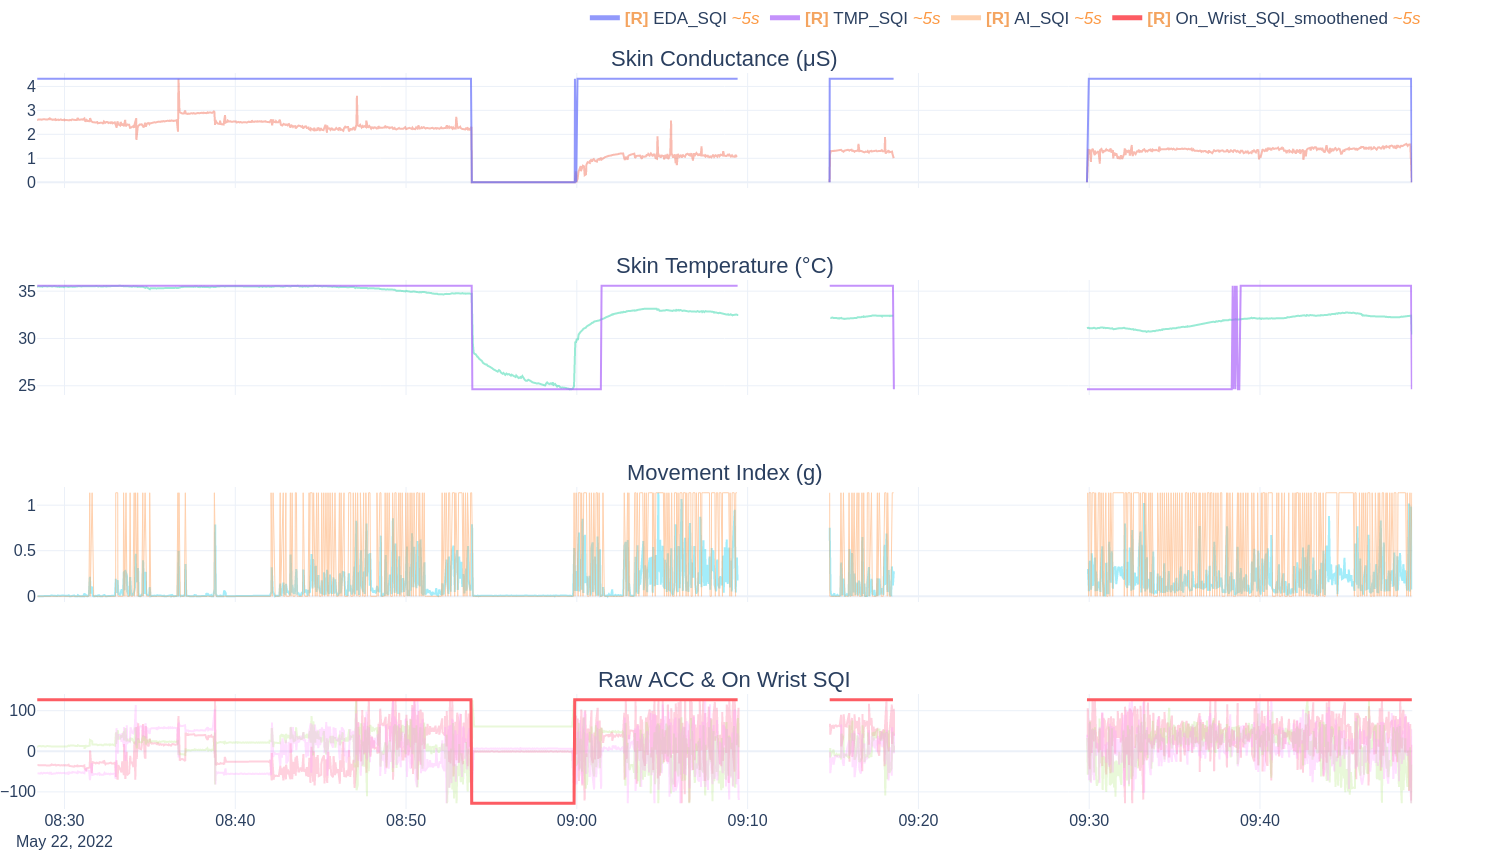

In [7]:
n_rows = 4
if True:
    specs = [[{"secondary_y": True}] for _ in range(n_rows)]
    fig = FigureResampler(
        make_subplots(
            rows=n_rows,
            specs=np.reshape(specs, (-1, 1)).tolist(),
            cols=1,
            shared_xaxes=True,
            subplot_titles=[
                "Skin Conductance (μS)",
                "Skin Temperature (°C)",
                "Movement Index (g)",
                "Raw ACC & On Wrist SQI",
            ],
        )
    )

# ROW 1 -----------------------------------------------------
for col in ["EDA_SQI"]:
    # s_c = out[col]
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col, opacity=0.7),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        secondary_y=True,
    )

for col in df_eda.columns:
    s_c = df_eda[col]
    # s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col, opacity=0.4, showlegend=False), hf_x=s_c.index, hf_y=s_c
    )
    # fig.update_yaxes(range=[-.6, s_c.max() + .3], row=1, col=1, secondary_y=False)

# ROW 2 -----------------------------------------------------
for col in df_tmp.columns:
    fig.add_trace(
        go.Scatter(name=col, opacity=0.4, showlegend=False),
        hf_x=df_tmp[col].index,
        hf_y=df_tmp[col],
        row=2,
        col=1,
    )


for col in ["TMP_SQI"]:
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col, opacity=0.7),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        row=2,
        col=1,
        secondary_y=True,
    )

# ROW 3 -----------------------------------------------------
for col in ["AI_SQI"]:
    # s_c = out[col]
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col, opacity=0.5, line_width=1),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        secondary_y=True,
        row=3,
        col=1,
    )

for col in ["AI"]:
    # s_c = out[col]
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col, opacity=0.4, showlegend=False),
        hf_x=s_c.index,
        hf_y=s_c,
        row=3,
        col=1,
    )


# ROW 4 -----------------------------------------------------
for col in df_acc.columns:
    fig.add_trace(
        go.Scatter(name=col, opacity=0.3, showlegend=False),
        hf_x=df_acc[col].index,
        hf_y=df_acc[col],
        row=4,
        col=1,
    )

for col in ["Wrist_SQI", "On_Wrist_SQI_smoothened"][1:]:
    # s_c = out[col]
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col, line_color="#fd5c63", line_width=3),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        row=4,
        col=1,
        secondary_y=True,
    )


# ROW 5 -----------------------------------------------------
# for col in df_bvp.columns:
#     s_c = df_bvp[col]
#     fig.add_trace(
#         go.Scatter(name=col, opacity=0.5), hf_x=s_c.index, hf_y=s_c, row=5, col=1
#     )


fig.update_layout(template="plotly_white", height=750)  # , title=user_s, title_x=0.5)
fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        x=0.95,
        font_size=17,
        itemsizing="constant",
    )
)
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
fig.update_annotations(font_size=22)
# update tick sizes
fig.update_xaxes(tickfont_size=16)
fig.update_yaxes(tickfont_size=16)
# do not show seconds on the y-axis
fig.update_yaxes(visible=False, secondary_y=True)

# fig.show_dash(mode="inline", port=9035)
fig.show(renderer="png", width=1500, height=850)

### Böttcher

In [8]:
out_bottcher = wrist_pipeline_bottcher.process(
    [df_eda, df_tmp, df_acc],
    return_df=False,
    drop_keys=["ACC_x", "ACC_y", "ACC_z", "EDA"],
    logging_file_path="wrist_on_off_.log",
)
# display(out['Wrist_SQI_smoothened'].isna().value_counts())
# out['Wrist_SQI_smoothened'].bfill(inplace=True) #= out['Wrist_SQI_smoothened'].bfill()
pl = get_processor_logs("wrist_on_off_.log").drop(columns=["log_time"])
display(pl)  # , 'duration']))
print(
    round(pl.duration.sum().total_seconds() / (len(df_eda) / (4 * 60 * 60)), 5),
    "seconds per hour",
)

/home/jonas/.cache/pypoetry/virtualenvs/data-quality-wearables-JR_qNb0v-py3.9/lib/python3.9/site-packages/tsflex/utils/logging.py:81: RuntimeWarning:

Logging file (wrist_on_off_.log) already exists. This file will be overwritten!



,function,series_names,duration
0,dataframe_func: std_sum,"(ACC_x, ACC_y, ACC_z)",0 days 00:00:00.024120569
1,<lambda>,"(AI,)",0 days 00:00:00.000270367
2,<lambda>,"(EDA,)",0 days 00:00:00.000186920
3,<lambda>,"(TMP,)",0 days 00:00:00.000412226
4,<lambda>,"(EDA_SQI, TMP_SQI)",0 days 00:00:00.000673294
5,<lambda>,"(EDA_SQI, AI_SQI)",0 days 00:00:00.003083706
6,mean_resample,"(EDA_SQI,)",0 days 00:00:00.004852772
7,mean_resample,"(AI_SQI,)",0 days 00:00:00.001088142
8,mean_resample,"(TMP_SQI,)",0 days 00:00:00.001063585
9,mean_resample,"(EDA_SQI,)",0 days 00:00:00.001019478


0.03783 seconds per hour


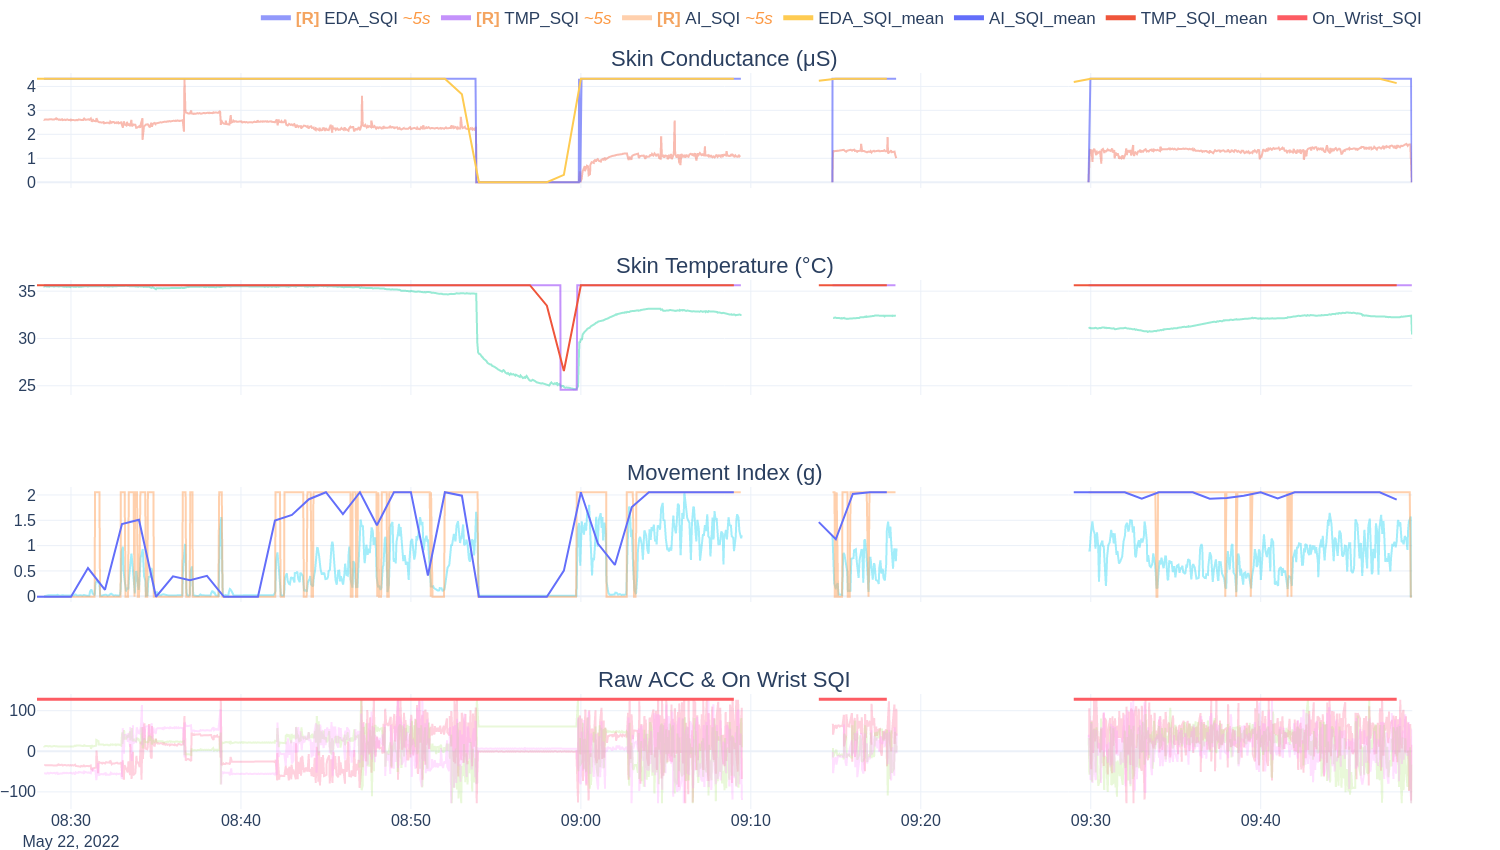

In [9]:
n_rows = 4
if True:
    specs = [[{"secondary_y": True}] for _ in range(n_rows)]
    fig = FigureResampler(
        make_subplots(
            rows=n_rows,
            specs=np.reshape(specs, (-1, 1)).tolist(),
            cols=1,
            shared_xaxes=True,
            subplot_titles=[
                "Skin Conductance (μS)",
                "Skin Temperature (°C)",
                "Movement Index (g)",
                "Raw ACC & On Wrist SQI",
            ],
        )
    )

fig.update_yaxes(range=[-0.05, 1.05], secondary_y=True, row=4, col=1)
fig.update_yaxes(range=[-0.05, 1.05], secondary_y=True, row=3, col=1)
fig.update_yaxes(range=[-0.05, 1.05], secondary_y=True, row=2, col=1)

# ROW 1 -----------------------------------------------------
for col in ["EDA_SQI"]:
    s_c = seq(out_bottcher).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col, opacity=0.7),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        secondary_y=True,
    )

for col in df_eda.columns:
    s_c = df_eda[col]
    fig.add_trace(
        go.Scatter(name=col, opacity=0.4, showlegend=False), hf_x=s_c.index, hf_y=s_c
    )

# ROW 2 -----------------------------------------------------
for col in df_tmp.columns:
    fig.add_trace(
        go.Scatter(name=col, opacity=0.4, showlegend=False),
        hf_x=df_tmp[col].index,
        hf_y=df_tmp[col],
        row=2,
        col=1,
    )


for col in ["TMP_SQI"]:
    s_c = seq(out_bottcher).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col, opacity=0.7),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        row=2,
        col=1,
        secondary_y=True,
    )

# ROW 3 -----------------------------------------------------
for col in ["AI_SQI"]:
    s_c = seq(out_bottcher).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col, opacity=0.5, line_width=2),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        secondary_y=True,
        row=3,
        col=1,
    )

for col in ["AI"]:
    s_c = seq(out_bottcher).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col, opacity=0.4, showlegend=False),
        hf_x=s_c.index,
        hf_y=s_c,
        row=3,
        col=1,
    )


# ROW 4 -----------------------------------------------------
for col in df_acc.columns:
    fig.add_trace(
        go.Scatter(name=col, opacity=0.3, showlegend=False),
        hf_x=df_acc[col].index,
        hf_y=df_acc[col],
        row=4,
        col=1,
    )

for col, row_idx in [("EDA_SQI_mean", 1), ("AI_SQI_mean", 3), ("TMP_SQI_mean", 2)][:]:
    s_c = seq(out_bottcher).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        row=row_idx,
        col=1,
        secondary_y=True,
        limit_to_view=True,
    )


# ROW 5 -----------------------------------------------------
for col, row_idx in [
    ("EDA_SQI_mean_bin", 1),
    ("AI_SQI_mean_bin", 3),
    ("TMP_SQI_mean_bin", 2),
    ("On_Wrist_SQI", 4),
][-1:]:
    s_c = seq(out_bottcher).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(
            name=col,
            line_width=3 if "wrist_sqi" in col.lower() else 2,
            line_color="#fd5c63" if "wrist_sqi" in col.lower() else None,
        ),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        secondary_y=True,
        limit_to_view=True,
        row=row_idx,
        col=1,
    )


fig.update_layout(template="plotly_white", height=750)  # , title=user_s, title_x=0.5)
fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        x=0.95,
        font_size=17,
        itemsizing="constant",
    )
)
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
fig.update_annotations(font_size=22)
# update tick sizes
fig.update_xaxes(tickfont_size=16)
fig.update_yaxes(tickfont_size=16)
# do not show seconds on the y-axis
fig.update_yaxes(visible=False, secondary_y=True)
# fig.show_dash(mode="inline", port=9035)
fig.show(renderer="png", width=1500, height=850)

## Backtest on labeled data

Through leveraging `plotly-resampler`, we can backtest both non weare detection algorithms on large bouts of time series data.

The data was labeled via the [label_off_wrist](2.0_Label_off_wrist.ipynb) notebook

In [7]:
df_meta = pd.read_csv("df_meta.csv", parse_dates=["start", "end"])
df_meta["start"] = df_meta["start"].dt.tz_localize("Europe/Brussels", ambiguous="NaT")
df_meta["end"] = df_meta["end"].dt.tz_localize("Europe/Brussels", ambiguous="NaT")
print(df_meta.shape)
df_meta = df_meta.dropna(subset=["start", "end"])
print(df_meta.shape)

# ensure that the start is before the end
start = df_meta[["start", "end"]].min(axis=1)
end = df_meta[["start", "end"]].max(axis=1)
df_meta["start"] = start
df_meta["end"] = end
assert all(df_meta["start"] <= df_meta["end"])

df_meta["duration"] = df_meta["end"] - df_meta["start"]
df_meta[df_meta.label == "off-wrist"].groupby("patient_id")["duration"].agg(
    ["sum", "count"]
)

(1167, 5)
(1165, 5)


,sum,count
patient_id,,
MBRAIN21-001,0 days 03:54:12.261000,24
MBRAIN21-004,0 days 03:13:50.461000,14
MBRAIN21-005,0 days 05:00:33.094000,2
MBRAIN21-008,1 days 00:54:08.882000,76
MBRAIN21-009,0 days 00:25:27.320000,1
MBRAIN21-014,0 days 00:11:15.437000,1
MBRAIN21-021,0 days 00:05:38.468000,1
MBRAIN21-022,0 days 04:48:03.531000,11


In [48]:
from typing import List
from pathlib import Path

obelisk_dir = processed_mbrain_path


def get_all_user_empatica_data(ptcpt_name, signal="gsr") -> pd.DataFrame:
    eligible_files: List[Path] = []
    for folder in obelisk_dir.glob(f"{ptcpt_name}.empatica.E4*"):
        eligible_files.extend(list(folder.glob(f"{signal}_*")))

    data = []
    for eligible_file in eligible_files:
        pqt = pd.read_parquet(eligible_file)
        if "timestamp" in pqt.columns:
            pqt.set_index("timestamp", inplace=True)
        if len(pqt):
            data.append(pqt)
    if len(data):
        out = pd.concat(data, copy=False).sort_index()
        return out[~out.index.duplicated()]
    else:
        return pd.DataFrame()

In [49]:
user = "MBRAIN21-008"  # fetch all the data of this user
e4_tmp = get_all_user_empatica_data(user, "tmp")
e4_ibi = get_all_user_empatica_data(user, "ibi")
e4_eda = get_all_user_empatica_data(user, "gsr")
e4_acc = get_all_user_empatica_data(user, "acc")
# e4_bvp = get_all_user_empatica_data(user, "bvp")

### Our SQI

In [50]:
out = wrist_pipeline.process(
    [e4_eda, e4_tmp, e4_acc],
    return_df=False,
    drop_keys=["ACC_x", "ACC_y", "ACC_z", "EDA"],
    logging_file_path="wrist_on_off_.log",
)
# display(out['Wrist_SQI_smoothened'].isna().value_counts())
# out['Wrist_SQI_smoothened'].bfill(inplace=True) #= out['Wrist_SQI_smoothened'].bfill()
pl = get_processor_logs("wrist_on_off_.log").drop(columns=["log_time"])
display(pl)  # , 'duration']))
print(
    round(pl.duration.sum().total_seconds() / (len(e4_eda) / (4 * 60 * 60)), 5),
    "seconds per hour",
)

/home/jonas/.cache/pypoetry/virtualenvs/data-quality-wearables-JR_qNb0v-py3.9/lib/python3.9/site-packages/tsflex/utils/logging.py:81: RuntimeWarning: Logging file (wrist_on_off_.log) already exists. This file will be overwritten!
  warnings.warn(


,function,series_names,duration
0,<lambda>,"(ACC_x,)",0 days 00:00:02.120868921
1,<lambda>,"(EDA,)",0 days 00:00:00.006701946
2,<lambda>,"(TMP,)",0 days 00:00:00.006883383
3,<lambda>,"(AI,)",0 days 00:00:00.008509398
4,<lambda>,"(EDA_SQI, TMP_SQI)",0 days 00:00:02.068068027
5,<lambda>,"(EDA_SQI, AI_SQI)",0 days 00:00:02.040124893
6,sqi_or,"(EDA_SQI, TMP_SQI, AI_SQI)",0 days 00:00:00.022334576
7,sqi_smoothen,"(On_Wrist_SQI,)",0 days 00:00:00.366673708
8,sqi_smoothen,"(On_Wrist_SQI_smoothened,)",0 days 00:00:00.345476627


0.00598 seconds per hour


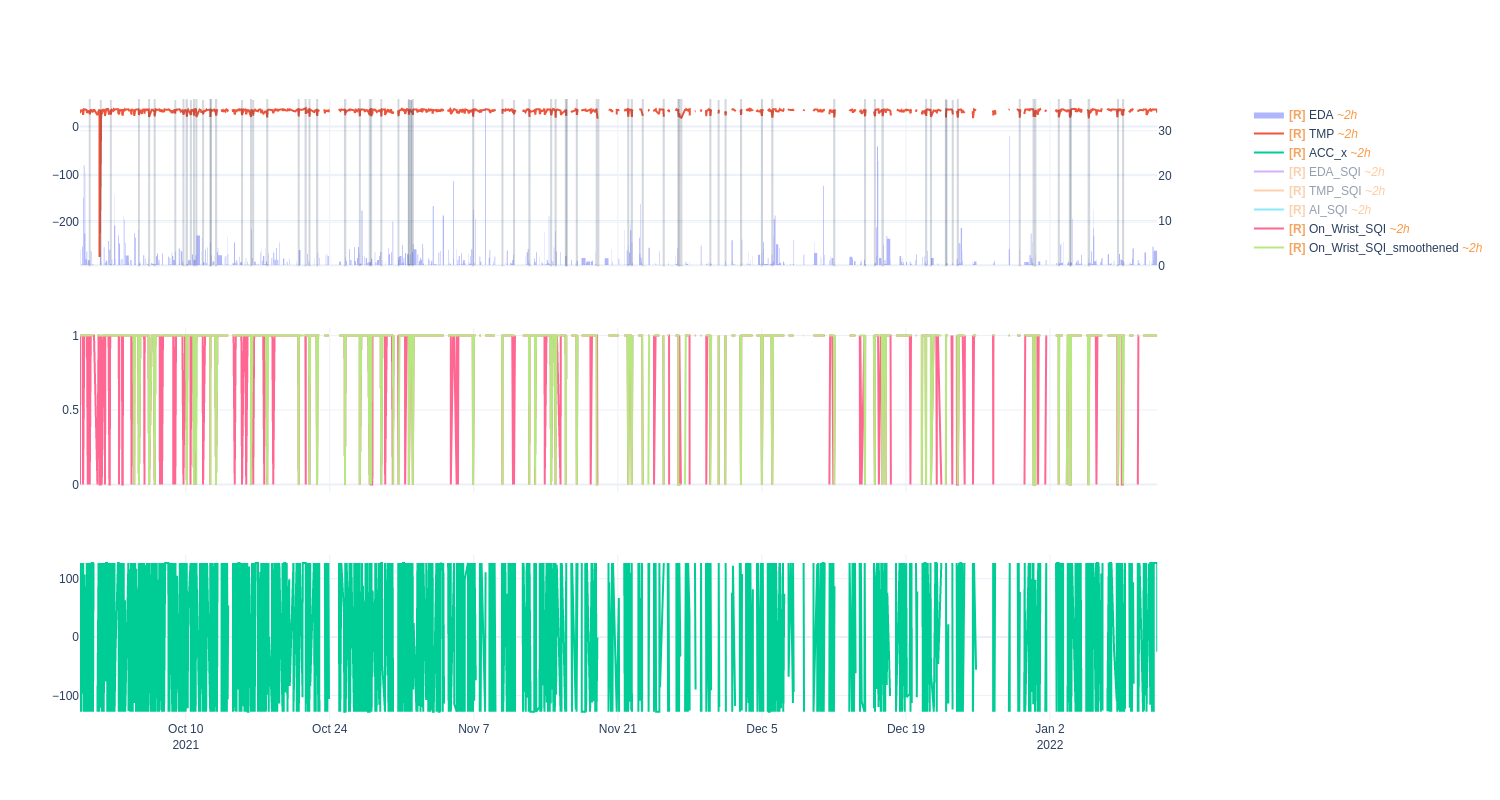

In [53]:
from plotly_resampler.aggregation import MinMaxLTTB
from plotly_resampler.aggregation.gap_handlers import MedDiffGapHandler

fig = FigureResampler(
    make_subplots(
        rows=3, cols=1, shared_xaxes=True, specs=[[{"secondary_y": True}]] * 3
    ),
    default_downsampler=MinMaxLTTB(parallel=True),
)
# fmt: off
fig.add_trace(go.Scatter(name="EDA", opacity=0.5, fill='tozeroy', line_shape='vh', line_width=0), gap_handler=MedDiffGapHandler(fill_value=0), hf_x=e4_eda.index, hf_y=e4_eda["EDA"], row=1, col=1, secondary_y=True)
fig.add_trace(go.Scatter(name="TMP"), hf_x=e4_tmp.index, hf_y=e4_tmp["TMP"], row=1, col=1)

fig.add_trace(go.Scatter(name='ACC_x'), hf_x=e4_acc.index, hf_y=e4_acc["ACC_x"], row=3, col=1)
# fig.add_trace(go.Scatter(name="BVP"), hf_x=e4_bvp.index, hf_y=e4_bvp["BVP"], row=3, col=1, secondary_y=True)

# fmt: on
for col in ["EDA_SQI", "TMP_SQI", "AI_SQI"]:
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col, visible="legendonly"),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        row=2,
        col=1,
    )
for col in ["On_Wrist_SQI", "On_Wrist_SQI_smoothened"]:
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        row=2,
        col=1,
    )

for _, r in df_meta[
    (df_meta["patient_id"] == user) & (df_meta.label == "off-wrist")
].iterrows():
    fig.add_vrect(x0=r.start, x1=r.end, row=1, col=1, fillcolor="red", opacity=0.2)
fig.update_layout(template="plotly_white", height=800)
fig.show(renderer='png', width=1500)
fig.show_dash(mode="inline", port=8022)

### Bottcher

In [ ]:
out = wrist_pipeline_bottcher.process(
    [e4_eda, e4_tmp, e4_acc],
    return_df=False,
    drop_keys=["ACC_x", "ACC_y", "ACC_z", "EDA"],
    logging_file_path="wrist_on_off_.log",
)
# display(out['Wrist_SQI_smoothened'].isna().value_counts())
# out['Wrist_SQI_smoothened'].bfill(inplace=True) #= out['Wrist_SQI_smoothened'].bfill()
pl = get_processor_logs("wrist_on_off_.log").drop(columns=["log_time"])
display(pl)  # , 'duration']))
print(
    round(pl.duration.sum().total_seconds() / (len(e4_eda) / (4 * 60 * 60)), 5),
    "seconds per hour",
)

/home/jonas/.cache/pypoetry/virtualenvs/data-quality-wearables-JR_qNb0v-py3.9/lib/python3.9/site-packages/tsflex/utils/logging.py:81: RuntimeWarning:

Logging file (wrist_on_off_.log) already exists. This file will be overwritten!



,function,series_names,duration
0,dataframe_func: std_sum,"(ACC_x, ACC_y, ACC_z)",0 days 00:00:50.220240355
1,<lambda>,"(AI,)",0 days 00:00:00.102858305
2,<lambda>,"(EDA,)",0 days 00:00:00.006715298
3,<lambda>,"(TMP,)",0 days 00:00:00.017571449
4,<lambda>,"(EDA_SQI, TMP_SQI)",0 days 00:00:00.115325928
5,<lambda>,"(EDA_SQI, AI_SQI)",0 days 00:00:24.518437386
6,mean_resample,"(EDA_SQI,)",0 days 00:00:00.758136272
7,mean_resample,"(AI_SQI,)",0 days 00:00:00.199017286
8,mean_resample,"(TMP_SQI,)",0 days 00:00:00.199748278
9,mean_resample,"(EDA_SQI,)",0 days 00:00:00.200787783


0.06571 seconds per hour


In [ ]:
from plotly_resampler.aggregation import MinMaxLTTB
from plotly_resampler.aggregation.gap_handlers import MedDiffGapHandler

fig = FigureResampler(
    make_subplots(
        rows=3, cols=1, shared_xaxes=True, specs=[[{"secondary_y": True}]] * 3
    ),
    default_downsampler=MinMaxLTTB(parallel=True),
)
# fmt: off
fig.add_trace(go.Scatter(name="EDA", opacity=0.5, fill='tozeroy', line_shape='vh', line_width=0), gap_handler=MedDiffGapHandler(fill_value=0), hf_x=e4_eda.index, hf_y=e4_eda["EDA"], row=1, col=1, secondary_y=True)
fig.add_trace(go.Scatter(name="TMP"), hf_x=e4_tmp.index, hf_y=e4_tmp["TMP"], row=1, col=1)

fig.add_trace(go.Scatter(name='ACC_x'), hf_x=e4_acc.index, hf_y=e4_acc["ACC_x"], row=3, col=1)
# fig.add_trace(go.Scatter(name="BVP"), hf_x=e4_bvp.index, hf_y=e4_bvp["BVP"], row=3, col=1, secondary_y=True)

# fmt: on
for col in ["EDA_SQI", "TMP_SQI", "AI_SQI"]:
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col, visible="legendonly"),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        row=2,
        col=1,
    )
for col in ["On_Wrist_SQI"]:
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        row=2,
        col=1,
    )

for _, r in df_meta[
    (df_meta["patient_id"] == user) & (df_meta.label == "off-wrist")
].iterrows():
    fig.add_vrect(x0=r.start, x1=r.end, row=1, col=1, fillcolor="red", opacity=0.2)
fig.update_layout(template="plotly_white", height=800, margin=dict(l=0, r=0, t=0, b=0))
fig.show_dash(mode="inline", port=8022)


## Validate both methods using metrics

In [9]:
from sklearn.metrics import classification_report
from code_utils.mbrain.conf import MBRAIN_USERS
from code_utils.utils.dataframes import groupby_consecutive

from tqdm.auto import tqdm


Note: the code below can take some time as *all* data (e.g. ~90days) per paricipant is used to compute the metrics.

In [45]:
on_wrist_SQI_list, on_wrist_SQI_Bottcher_list = [], []

for user in tqdm(MBRAIN_USERS[:]):
    e4_tmp = get_all_user_empatica_data(user, "tmp")
    e4_ibi = get_all_user_empatica_data(user, "ibi")
    e4_eda = get_all_user_empatica_data(user, "gsr")
    e4_acc = get_all_user_empatica_data(user, "acc")

    on_wrist_SQI = (
        seq(wrist_pipeline.process([e4_eda, e4_tmp, e4_acc]))
        .filter(lambda x: x.name == "On_Wrist_SQI_smoothened")
        .to_list()[0]
        .rename("On_Wrist_SQI")
        .to_frame()
    )

    # We resample the on-wrist SQI to 1 minute intervals (as this is the case for the 
    # BOTTCHER SQI
    # If you comment out the following two lines, our on-wrist SQI score would even 
    # lie higher! :)
    on_wrist_SQI.index = on_wrist_SQI.index.round("1min", ambiguous="NaT")
    on_wrist_SQI = on_wrist_SQI[
        ~on_wrist_SQI.index.duplicated(keep="first") & on_wrist_SQI.index.notna()
    ]

    on_wrist_SQI_Bottcher = (
        seq(wrist_pipeline_bottcher.process([e4_eda, e4_tmp, e4_acc], return_df=False))
        .filter(lambda x: x.name == "On_Wrist_SQI")
        .to_list()[0]
        .to_frame()
    )
    del e4_tmp, e4_ibi, e4_eda, e4_acc

    # Add the label and user information to both SQI's
    on_wrist_SQI["label"] = True
    on_wrist_SQI["user"] = user

    on_wrist_SQI_Bottcher["label"] = True
    on_wrist_SQI_Bottcher["user"] = user

    for _, r in df_meta[
        (df_meta["patient_id"] == user)
        & (df_meta.label == "off-wrist")
        & (df_meta.duration > pd.Timedelta("1min"))
    ].iterrows():
        on_wrist_SQI.loc[r.start : r.end, "label"] = False
        on_wrist_SQI_Bottcher.loc[r.start : r.end, "label"] = False

    # Assign an (equal) weight to each consecutive period of on-wrist
    # i.e. ensure that the sum of all period samples is one
    # This should ensure that short off-wrist periods are not underrepresented
    # compared to long off-wrist periods
    groups = groupby_consecutive(on_wrist_SQI["label"])
    groups["weight"] = 1 / groups["n_consecutive"]
    on_wrist_SQI["weight"] = None
    for _, r in groups.iterrows():
        on_wrist_SQI.loc[r.start : r.end, "weight"] = r.weight
    on_wrist_SQI["weight"] = on_wrist_SQI["weight"].astype(float)

    groups = groupby_consecutive(on_wrist_SQI_Bottcher["label"])
    groups["weight"] = 1 / groups["n_consecutive"]
    on_wrist_SQI_Bottcher["weight"] = None
    for _, r in groups.iterrows():
        on_wrist_SQI_Bottcher.loc[r.start : r.end, "weight"] = r.weight
    on_wrist_SQI_Bottcher["weight"] = on_wrist_SQI_Bottcher["weight"].astype(float)

    on_wrist_SQI_list.append(on_wrist_SQI)
    on_wrist_SQI_Bottcher_list.append(on_wrist_SQI_Bottcher)

on_wrist_SQI = pd.concat(on_wrist_SQI_list)
on_wrist_SQI_Bottcher = pd.concat(on_wrist_SQI_Bottcher_list)


  0%|          | 0/3 [00:00<?, ?it/s]

`Ours`

In [46]:
print(
    classification_report(
        on_wrist_SQI["On_Wrist_SQI"],
        on_wrist_SQI["label"],
        sample_weight=on_wrist_SQI["weight"],
    )
)
print(classification_report(on_wrist_SQI["On_Wrist_SQI"], on_wrist_SQI["label"]))

              precision    recall  f1-score   support

       False       0.86      0.98      0.92 61.4961101638719
        True       0.98      0.88      0.93 81.5038898358489

    accuracy                           0.92 142.99999999972079
   macro avg       0.92      0.93      0.92 142.99999999972079
weighted avg       0.93      0.92      0.92 142.99999999972079

              precision    recall  f1-score   support

       False       0.95      0.83      0.89      1921
        True       1.00      1.00      1.00    218128

    accuracy                           1.00    220049
   macro avg       0.97      0.92      0.94    220049
weighted avg       1.00      1.00      1.00    220049



`Böttcher`

In [47]:
print(
    classification_report(
        on_wrist_SQI_Bottcher["On_Wrist_SQI"],
        on_wrist_SQI_Bottcher["label"],
        sample_weight=on_wrist_SQI_Bottcher["weight"],
    )
)
print(
    classification_report(
        on_wrist_SQI_Bottcher["On_Wrist_SQI"],
        on_wrist_SQI_Bottcher["label"],
    )
)


              precision    recall  f1-score   support

       False       0.50      1.00      0.66 34.71047561429688
        True       1.00      0.67      0.80 107.28952438617267

    accuracy                           0.75 142.00000000046956
   macro avg       0.75      0.84      0.73 142.00000000046956
weighted avg       0.88      0.75      0.77 142.00000000046956

              precision    recall  f1-score   support

       False       0.76      1.00      0.86      1278
        True       1.00      1.00      1.00    219007

    accuracy                           1.00    220285
   macro avg       0.88      1.00      0.93    220285
weighted avg       1.00      1.00      1.00    220285

